In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np

import os, sys

import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ROOT_DIR = 'training/'
IMAGE_DIR = ROOT_DIR + 'images/'

In [41]:
def train(features, labels, model, lossfunc, optimizer, num_epoch):
    x = features
    y = labels
    for epoch in range(num_epoch):

        # TODO: Step 2 - compute model predictions and loss
        preds = model(x)
        loss = lossfunc(preds, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epoch, loss.data[0]))

def load_image(filename):
    return mpimg.imread(filename)

#def unstack(img):
#    return np.array([img[:,:,c] for c in range(3)])

#def restack(img):
#    return np.stack(img, axis=-1)

In [4]:
# Read images
files = os.listdir(IMAGE_DIR)
imgs = [load_image(IMAGE_DIR + file) for file in files] # images (400, 400, 3)

In [5]:
# Build train tensor

X_var = Variable(torch.from_numpy(np.stack(imgs))) # tensor (N, W, H, C)
#X_var = Variable(torch.from_numpy(np.stack(imgs[:7])))

In [6]:
# Reshapers models

class NCWHtoNWHC(nn.Module):
    def __init__(self):
        super(NCWHtoNWHC, self).__init__()
    def forward(self, x):
        return x.permute(0,2,3,1)
    
class NWHCtoNCWH(nn.Module):
    def __init__(self):
        super(NWHCtoNCWH, self).__init__()
    def forward(self, x):
        return x.permute(0, 3, 1, 2)
    
class Squeezer1(nn.Module):
    def __init__(self):
        super(Squeezer1, self).__init__()
    def forward(self, x):
        return x.squeeze(dim=1)

In [7]:
# Funky and completely random model

conv = nn.Sequential(
    NWHCtoNCWH(), # Pass from (N,W,H,C) to (N, C, W, H) required for convolutions and pooling
    nn.Conv2d(in_channels=3,
              out_channels=3,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=3,
              out_channels=3,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=3,
              out_channels=3,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
)

learn = nn.Sequential(
    NCWHtoNWHC(), # Return to (N,W,H,C) to use the channel components as features
    nn.Linear(3, 7),
    nn.ReLU(),
    nn.Linear(7, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.ReLU()
)

resize = nn.Sequential(
    NWHCtoNCWH(), # Return to N,C,W,H so that Upsame can rescale patch to whole image
    nn.Upsample(scale_factor=8),
    Squeezer1() # From N,1,W,H to N,W,H
)

model = nn.Sequential(conv, learn, resize)

In [8]:
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
costf = torch.nn.MSELoss()

In [9]:
# Read groundtruts

GT_DIR = ROOT_DIR + 'groundtruth/'
gt_imgs = [load_image(GT_DIR + file) for file in files] # images (400, 400)

In [10]:
# Build groundtruth tensor

Y_var = Variable(torch.from_numpy(np.stack(gt_imgs)))
#Y_var = Variable(torch.from_numpy(np.stack(gt_imgs[:7])))

In [11]:
train(X_var, Y_var, model, costf, optimizer, 100)

Epoch [1/100], Loss: 0.1411
Epoch [11/100], Loss: 0.1414
Epoch [21/100], Loss: 0.1414
Epoch [31/100], Loss: 0.1414
Epoch [41/100], Loss: 0.1408
Epoch [51/100], Loss: 0.1409
Epoch [61/100], Loss: 0.1410
Epoch [71/100], Loss: 0.1413
Epoch [81/100], Loss: 0.1491
Epoch [91/100], Loss: 0.1493


In [44]:
# Choose image to analyze
img = imgs[0]

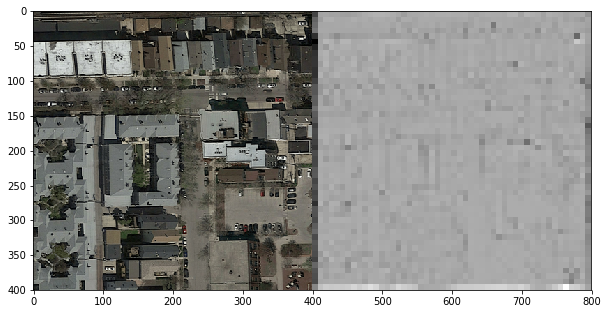

In [42]:
# Predict and give correct shape
test_x = Variable(torch.from_numpy(img).unsqueeze(0))
preds = model(test_x).squeeze(0).data.numpy()

# Draw
cimg = utils.concatenate_images(img, preds)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

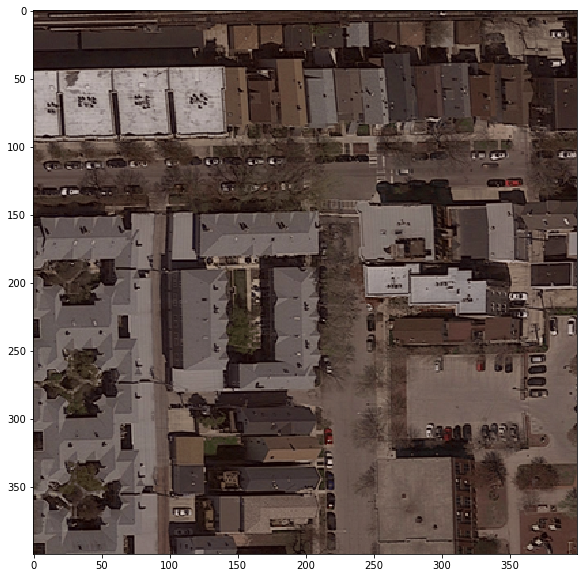

In [43]:
new_img = utils.make_img_overlay(img, preds)
plt.figure(figsize=(10,10))
plt.imshow(new_img)